In [1]:
import numpy as np 
import pandas as pd 


In [2]:
import os

dataset_path = '/kaggle/input/weather-dataset'
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {len(files)} files")


Root: /kaggle/input/weather-dataset
Directories: ['dataset']
Files: 0 files
Root: /kaggle/input/weather-dataset/dataset
Directories: ['hail', 'rainbow', 'frost', 'rime', 'fogsmog', 'snow', 'rain', 'glaze', 'lightning', 'sandstorm', 'dew']
Files: 0 files
Root: /kaggle/input/weather-dataset/dataset/hail
Directories: []
Files: 591 files
Root: /kaggle/input/weather-dataset/dataset/rainbow
Directories: []
Files: 232 files
Root: /kaggle/input/weather-dataset/dataset/frost
Directories: []
Files: 475 files
Root: /kaggle/input/weather-dataset/dataset/rime
Directories: []
Files: 1160 files
Root: /kaggle/input/weather-dataset/dataset/fogsmog
Directories: []
Files: 851 files
Root: /kaggle/input/weather-dataset/dataset/snow
Directories: []
Files: 621 files
Root: /kaggle/input/weather-dataset/dataset/rain
Directories: []
Files: 526 files
Root: /kaggle/input/weather-dataset/dataset/glaze
Directories: []
Files: 639 files
Root: /kaggle/input/weather-dataset/dataset/lightning
Directories: []
Files: 377 

In [3]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),  # Resize all images to 224x224
    batch_size=32          # Batch size
)

for images, labels in dataset.take(1):
    print(images.shape, labels.shape)


Found 6862 files belonging to 1 classes.
(32, 224, 224, 3) (32,)


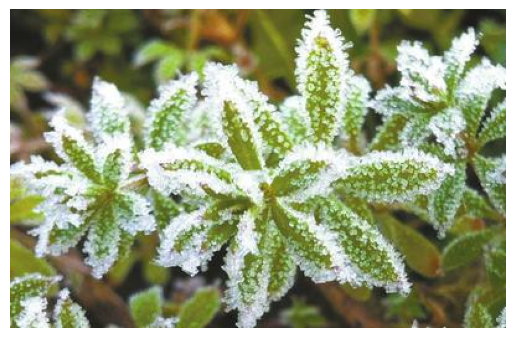

In [4]:
import cv2
import matplotlib.pyplot as plt

sample_image_path = os.path.join('/kaggle/input/weather-dataset/dataset', 'frost', '3600.jpg')

image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(image)
plt.axis('off')
plt.show()


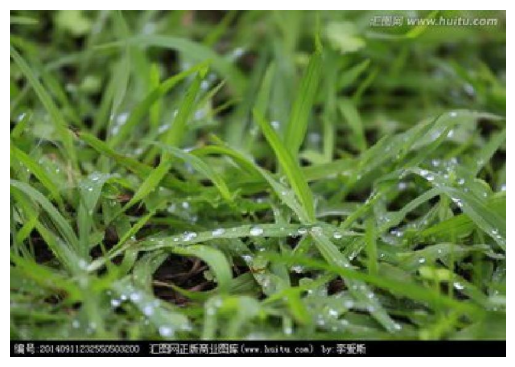

In [5]:
sample_image_path = os.path.join('/kaggle/input/weather-dataset/dataset', 'dew', '2210.jpg')

image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
device = torch.device("cpu")
print(f"Running on device: {device}")

Running on device: cpu


In [14]:
data_dir = "/kaggle/input/weather-dataset/dataset"

In [15]:
img_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
dataset = datasets.ImageFolder(root=data_dir, transform=img_transforms)


In [18]:
train_set, test_set = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])


In [19]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True, pin_memory=False)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True, pin_memory=False)


In [10]:
train_set, test_set = random_split(dataset=dataset,lengths=[0.8,0.2])

In [21]:
model = models.resnet18(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return train_loss_history


In [24]:
# Evaluation 
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [26]:
# Visualization
def visualize_results(loader, model):
    class_names = dataset.classes
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(loader))
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        fig = plt.figure(figsize=(15, 10))
        for idx in range(8):  # Show 8 images
            ax = fig.add_subplot(2, 4, idx + 1)
            ax.imshow(images[idx].permute(1, 2, 0).numpy())
            ax.title.set_text(f"Predicted: {class_names[preds[idx]]}\nActual: {class_names[labels[idx]]}")
            ax.axis("off")
        plt.show()


In [27]:
num_epochs = 10
print("Training the model...")
train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs)


Training the model...
Epoch 1/10, Loss: 0.9497
Epoch 2/10, Loss: 0.6463
Epoch 3/10, Loss: 0.5104
Epoch 4/10, Loss: 0.4047
Epoch 5/10, Loss: 0.3626
Epoch 6/10, Loss: 0.2726
Epoch 7/10, Loss: 0.2040
Epoch 8/10, Loss: 0.1987
Epoch 9/10, Loss: 0.1773
Epoch 10/10, Loss: 0.1192


In [28]:
print("Evaluating the model...")
evaluate_model(model, test_loader)

Evaluating the model...
Test Accuracy: 74.36%


74.36270939548434

Visualizing results...


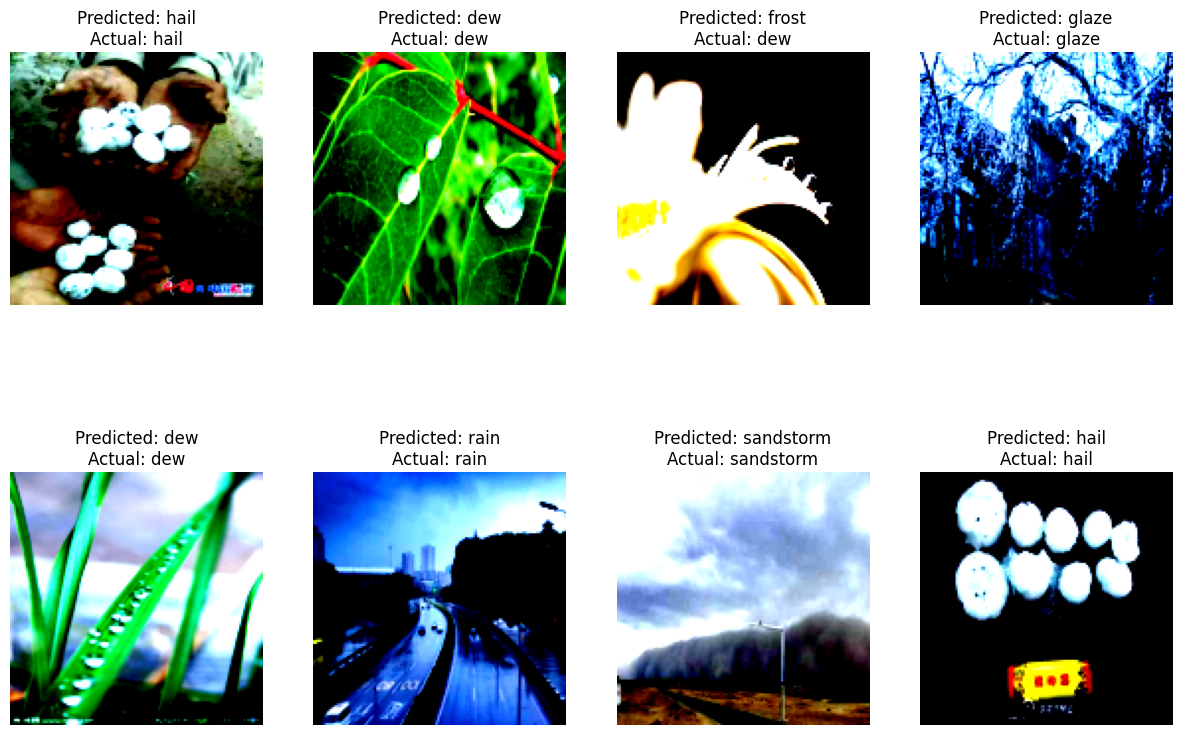

In [29]:
# Visualize predictions
print("Visualizing results...")
visualize_results(test_loader, model)

In [30]:
torch.save(model.state_dict(), "weather_classification_model_cpu.pth")
print("Model saved!")

Model saved!
